# 导包

In [51]:
import torch
import torchvision
import torch.nn
import torch.nn.init
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import collections

1.4.0+cpu
0.5.0+cpu
False


In [54]:
import nlp
import rnn
import basic
import data

In [53]:
import imp
imp.reload(nlp)

<module 'nlp' from 'C:\\Users\\bambo\\PycharmProjects\\ai_learning\\nlp.py'>

# 机器翻译及相关技术
机器翻译的特别之处在于输入和输出都是不定长的。

## 数据准备
### 读入文本
1. 读取文本
2. 替换法文空格为普通空格

字符在计算机里是以编码的形式存在，我们通常所用的空格是 `\x20` ，是在标准ASCII可见字符 `0x20~0x7e` 范围内。
而 `\xa0` 属于 `latin1 （ISO/IEC_8859-1）`中的扩展字符集字符，代表不间断空白符`nbsp(non-breaking space)`，超出`gbk`编码范围，是需要去除的特殊字符。

In [4]:
with open("DataSets/fra.txt",encoding="utf-8") as f:
    raw_text = f.read()
print(raw_text[0:1000])

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)
Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)
Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)
Run!	Courez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)
Who?	Qui ?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4366796 (gillux)
Wow!	Ça alors !	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #374631 (zmoo)
Fire!	Au feu !	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #4627939 (sacredceltic)
Help!	À l'aide !	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #128430 (sysko)
Jump.	Saute.	CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #2416938 (Phoenix)
Stop!	Ça suffit !	CC-BY 2.0 (France) Attribution: tato

字典的结构是
- 英语token
- 法语token
- 其他

In [5]:
len(raw_text)

25666314

In [6]:
def preprocess_raw(text):
    text = text.replace("\u202f"," ").replace("\xa0"," ")
    out = ""
    for i, char in enumerate(text.lower()):
        if char in (",","!",".") and i>0 and text[i-1]!=" ":
            out += " "
        out += char
    return out

In [7]:
# text = preprocess_raw(raw_text)
# print(text[0:1000])
# import pickle
# with open("Datasets/fr_text.pkl","wb") as f:
#     pickle.dump(text, f)

go .	va !	cc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)
hi .	salut !	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #509819 (aiji)
hi .	salut .	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #4320462 (gillux)
run !	cours !	cc-by 2 .0 (france) attribution: tatoeba .org #906328 (papabear) & #906331 (sacredceltic)
run !	courez !	cc-by 2 .0 (france) attribution: tatoeba .org #906328 (papabear) & #906332 (sacredceltic)
who?	qui ?	cc-by 2 .0 (france) attribution: tatoeba .org #2083030 (ck) & #4366796 (gillux)
wow !	ça alors !	cc-by 2 .0 (france) attribution: tatoeba .org #52027 (zifre) & #374631 (zmoo)
fire !	au feu !	cc-by 2 .0 (france) attribution: tatoeba .org #1829639 (spamster) & #4627939 (sacredceltic)
help !	à l'aide !	cc-by 2 .0 (france) attribution: tatoeba .org #435084 (lukaszpp) & #128430 (sysko)
jump .	saute .	cc-by 2 .0 (france) attribution: tatoeba .org #631038 (shishir) & #2416938 (phoenix)
stop !	ça suffit !	cc-b

In [31]:
with open("Datasets/fr_text.pkl","rb") as f:
    text = pickle.load(f)
print(text[0:1000])

go .	va !	cc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)
hi .	salut !	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #509819 (aiji)
hi .	salut .	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #4320462 (gillux)
run !	cours !	cc-by 2 .0 (france) attribution: tatoeba .org #906328 (papabear) & #906331 (sacredceltic)
run !	courez !	cc-by 2 .0 (france) attribution: tatoeba .org #906328 (papabear) & #906332 (sacredceltic)
who?	qui ?	cc-by 2 .0 (france) attribution: tatoeba .org #2083030 (ck) & #4366796 (gillux)
wow !	ça alors !	cc-by 2 .0 (france) attribution: tatoeba .org #52027 (zifre) & #374631 (zmoo)
fire !	au feu !	cc-by 2 .0 (france) attribution: tatoeba .org #1829639 (spamster) & #4627939 (sacredceltic)
help !	à l'aide !	cc-by 2 .0 (france) attribution: tatoeba .org #435084 (lukaszpp) & #128430 (sysko)
jump .	saute .	cc-by 2 .0 (france) attribution: tatoeba .org #631038 (shishir) & #2416938 (phoenix)
stop !	ça suffit !	cc-b

### 分词
文章字符串 -- 单词组成的（句子）的列表

In [8]:
num_examples = 50000
source, target = [],[]
for i, line in enumerate(text.split("\n")):
    if i > num_examples:
        break
    parts = line.split("\t")
    if len(parts) >= 2:
        source.append(parts[0].split(" "))
        target.append(parts[1].split(" "))

In [9]:
source[:3], target[:3]

([['go', '.'], ['hi', '.'], ['hi', '.']],
 [['va', '!'], ['salut', '!'], ['salut', '.']])

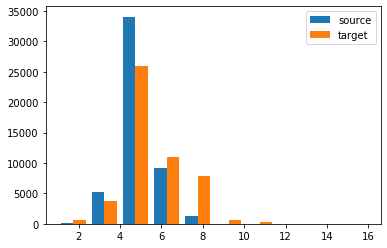

In [10]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist([[len(l) for l in source], [len(l) for l in target]], label=["source", "target"])
plt.legend(loc="upper right")

### 建立字典
`单词` → `id`的列表。

In [11]:
class Vocab_dict(object):
    """
    建立字典的语料库，单词级别。
    """
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        counter = collections.Counter(tokens)
        token_freqs = sorted(counter.items(), key=lambda x:x[0])
        token_freqs.sort(key=(lambda x:x[1]), reverse=True)
        if use_special_tokens:
            self.pad, self.bos, self.eos, self.unk = (0,1,2,3)
            tokens = ["<pad>","<bos>","<eos>","<unk>"]
        else:
            self.unk = 0
            tokens = ["<unk>"]
        tokens += [token for token, freq in token_freqs if freq >= min_freq]
        self.idx_to_token = []
        self.token_to_idx = dict()
        for token in tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, items):
        if not isinstance(items, (list, tuple)):
            return self.token_to_idx.get(items, self.unk)
        else:
            return [self.__getitem__(item) for item in items]

In [12]:
def build_vocab(tokens):
    """
    从字典建立语料库。
    :param tokens:
    :return:
    """
    tokens = [token for line in tokens for token in line]
    return nlp.Vocab_dict(tokens, min_freq=3, use_special_tokens=True)

In [13]:
src_vocab = build_vocab(source)
len(src_vocab)

3789

### 字符索引映射&长度补全

In [14]:
def pad(line, max_len, padding_token):
    """
    句子截断&补全。
    :param line: 分好词的句子。
    :param max_len: 最大长度。
    :param padding_token: 空白字符。
    :return: 
    """
    if len(line) > max_len:
        return line[:max_len]
    return line + [padding_token] * (max_len - len(line))

In [15]:
def build_array(lines, vocab, max_len, is_source):
    """
    建立字典的每一行从token转换为idx。
    :param lines: 字典。
    :param vocab: 字典语料库。
    :param max_len: 句子最大长度。
    :param is_source: 是否标注起始、结束。
    :return: array, valid_len
    """
    lines = [vocab[line] for line in lines]
    if not is_source:
        lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
    array = torch.tensor([pad(line, max_len, vocab.pad) for line in lines])
    valid_len = (array != vocab.pad).sum(dim=1)
    return array, valid_len

In [16]:
def load_data_nmt(source, target, batch_size, max_len): 
    """
    生成机器翻译字典的批量数据。
    :param batch_size: 批量大小。
    :param max_len: 句子长度上线。
    :return: 迭代器
    """
    src_vocab, tgt_vocab = nlp.build_vocab(source), nlp.build_vocab(target)
    src_array, src_valid_len = nlp.build_array(source, src_vocab, max_len, True)
    tgt_array, tgt_valid_len = nlp.build_array(target, tgt_vocab, max_len, False)
    train_data = data.TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    train_iter = data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [22]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(source, target, batch_size=2, max_len=8)

In [25]:
for X, X_valid_len, Y, Y_valid_len, in train_iter:
    print('X =', X.type(torch.int32), '\nValid lengths for X =', X_valid_len,
        '\nY =', Y.type(torch.int32), '\nValid lengths for Y =', Y_valid_len)
    break

X = tensor([[ 13,  91, 980,   4,   0,   0,   0,   0],
        [ 34, 318,  55,   7, 132,   4,   0,   0]], dtype=torch.int32) 
Valid lengths for X = tensor([4, 6]) 
Y = tensor([[   1,    5,   18,   27, 1215,    4,    2,    0],
        [   1,   33,   88,   24,  270,   19,  141,    4]], dtype=torch.int32) 
Valid lengths for Y = tensor([7, 8])


## encoder-decoder
![encoder-decode结构](https://cdn.kesci.com/upload/image/q5jcat3c8m.png?imageView2/0/w/640/h/640)

- encoder：输入到隐藏状态
- decoder：隐藏状态到输出

In [28]:
class Encoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [29]:
class Decoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [30]:
class EncoderDecoder(torch.nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## seq2seq
- 预测时decoder的输暑促和是下一步的输入。
- encoder的隐藏层状态传递给decoder。

### 模型训练  
![Image Name](https://cdn.kesci.com/upload/image/q5jc7a53pt.png?imageView2/0/w/640/h/640)

### 模型预测
![Image Name](https://cdn.kesci.com/upload/image/q5jcecxcba.png?imageView2/0/w/640/h/640)



### 具体结构：
输入先做embedding。

![Image Name](https://cdn.kesci.com/upload/image/q5jccjhkii.png?imageView2/0/w/500/h/500)

#### Encoder
本编码器以LSTM（`torch.nn.LSTM`）为基础：
- 输入X： (batch_size, seq_len, embed_size)；
- 输出Y： (seq_len, batch_size, num_hiddens)；
- LSTM的state： (num_layers, batch_size, num_hiddens)。
    - 隐藏状态
    - 记忆细胞，

In [32]:
class Seq2SeqEncoder(Encoder):
    """
    Encoder的具体实现。
    X shape: (batch_size, seq_len, embed_size)；
    Y shape: (seq_len, batch_size, num_hiddens)；
    LSTM的state包含最后一步的隐藏状态、记忆细胞，shape是 (num_layers, batch_size, num_hiddens)。
    """
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.rnn = torch.nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

    def begin_state(self, batch_size, device):
        return [torch.zeros(size=(self.num_layers, batch_size, self.num_hiddens), device=device),
                torch.zeros(size=(self.num_layers, batch_size, self.num_hiddens), device=device)]

    def forward(self, X, *args):
        X = self.embedding(X)  # X shape: (batch_size, seq_len, embed_size)
        X = X.transpose(0, 1)  # RNN needs first axes to be time
        # state = self.begin_state(X.shape[1], device=X.device)
        out, state = self.rnn(X)
        return out, state

In [33]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8,num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7),dtype=torch.long)
output, state = encoder(X)
output.shape, len(state), state[0].shape, state[1].shape

(torch.Size([7, 4, 16]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

#### Decoder

In [34]:
class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.rnn = torch.nn.LSTM(embed_size,num_hiddens, num_layers, dropout=dropout)
        self.dense = torch.nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).transpose(0, 1)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation.
        out = self.dense(out).transpose(0, 1)
        return out, state

In [35]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8,num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

## 损失函数
仅在有效长度求损失

### 有效长度掩码

In [41]:
def SequenceMask(X, X_len,value=0):
    """
    对于不定长序列求损失函数，仅在有效长度进行。
    :param X: (batch_size, maxlen)每一行是一个序列数据。
    :param X_len: (batch_size,)有效长度。
    :param value: mask。
    :return: 
    """
    maxlen = X.size(1)
    mask = torch.arange(maxlen)[None, :].to(X_len.device) < X_len[:, None]   
    X[~mask]=value
    return X

In [42]:
X = torch.tensor([[1,2,3], [4,5,6]])
SequenceMask(X,torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

### 带掩码的损失函数

In [45]:
class MaskedSoftmaxCELoss(torch.nn.CrossEntropyLoss):
    """
    带掩码的交叉熵损失函数类。
    
    X shape: (batch_size, seq_len, vocab_size)
    y shape: (batch_size, seq_len)
    valid_length shape: (batch_size, )
    """
    def forward(self, pred, label, valid_length):
        # the sample weights shape should be (batch_size, seq_len)
        weights = torch.ones_like(label)
        weights = SequenceMask(weights, valid_length).float()
        self.reduction='none'
        # (batch_size, vocab_size, seq_len) x (batch_size, seq_len) -> (batch_size, seq_len)
        output=super(MaskedSoftmaxCELoss, self).forward(pred.transpose(1,2), label)
        return (output*weights).mean(dim=1)

In [46]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones((3, 4, 10)), torch.ones((3,4),dtype=torch.long), torch.tensor([4,3,0]))

tensor([2.3026, 1.7269, 0.0000])

## 训练

In [62]:
def grad_clipping_nn(model, theta, device):
    grad_clipping(model.parameters(), theta, device)

In [63]:
def train_ch7(model, data_iter, lr, num_epochs, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    tic = time.time()
    for epoch in range(1, num_epochs + 1):
        l_sum, num_tokens_sum = 0.0, 0.0
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen - 1
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            
            l = loss(Y_hat, Y_label, Y_vlen).sum()
            l.backward()
            with torch.no_grad():
                rnn.grad_clipping(model.parameters(), 5, device)
            num_tokens = Y_vlen.sum().item()
            optimizer.step()
            
            l_sum += l.sum().item()
            num_tokens_sum += num_tokens
        if epoch % 50 == 0:
            print("epoch {0:4d},loss {1:.3f}, time {2:.1f} sec".format(
                epoch, (l_sum / num_tokens_sum), time.time() - tic))
            tic = time.time()

In [64]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_examples, max_len = 64, 1e3, 10

In [65]:
lr, num_epochs, ctx = 0.005, 300, basic.try_gpu()
src_vocab, tgt_vocab, train_iter = data.load_data_nmt(source, target, batch_size, max_len)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)

In [66]:
train_ch7(model, train_iter, lr, num_epochs, ctx)

KeyboardInterrupt: 

## 测试

In [ ]:
def translate_ch7(model, src_sentence, src_vocab, tgt_vocab, max_len, device):
    """
    机器翻译的enc-dec预测。
    :param model: encoder-decode模型。
    :param src_sentence: 待翻译语句。
    :param src_vocab: 源语言词典。
    :param tgt_vocab: 目标语言词典。
    :param max_len: 最大有效句子长度。
    :param device: CPU/GPU。
    :return: 翻译好的语句。
    """
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    src_len = len(src_tokens)
    if src_len < max_len:
        src_tokens += [src_vocab.pad] * (max_len - src_len)
    enc_X = torch.tensor(src_tokens, device=device)
    enc_valid_length = torch.tensor([src_len], device=device)
    enc_outputs = model.encoder(enc_X.unsqueeze(dim=0), enc_valid_length)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_length)
    dec_X = torch.tensor([tgt_vocab.bos], device=device).unsqueeze(dim=0)
    predict_tokens = []
    for _ in range(max_len):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next time step input.
        dec_X = Y.argmax(dim=2)
        py = dec_X.squeeze(dim=0).int().item()
        if py == tgt_vocab.eos:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

## 集束搜索
贪心搜搜，挑选较好的几个继续预测。

# 注意力机制及Seq2Seq模型

# Transformer